Some FLAMINGO data is analyzed (in the same was as investigate_field.ipynb).


In [48]:
import  matplotlib.pyplot as plt
plt.style.use("ggplot")
import numpy as np
import os
from scipy.fft import rfft2, irfft2 
from scipy.stats import kstest
import matplotlib.cm as cm
import h5py
from python_files.maxent import MaxEnt
import python_files.densities as d

In [49]:
path_to_projections = os.getcwd()+"/skewness_kurtosis/sliced_projections/"
types = ["DMO", "HYDRO"]
sims = ["PLANCK", "LOW_SIGMA8", "FIDUCIAL"]


#create empty dictionary: first level key is the type, second the sim
projections = dict.fromkeys(types, dict.fromkeys(sims))
for typ in types:
    for sim in sims:
        projections_data = h5py.File(path_to_projections+f'projected_maps_slice_5_L1000N1800_{typ}_{sim}_8192_lc0_alpha_3.6.h5','r')
        projections[typ][sim] = projections_data['proj_maps']



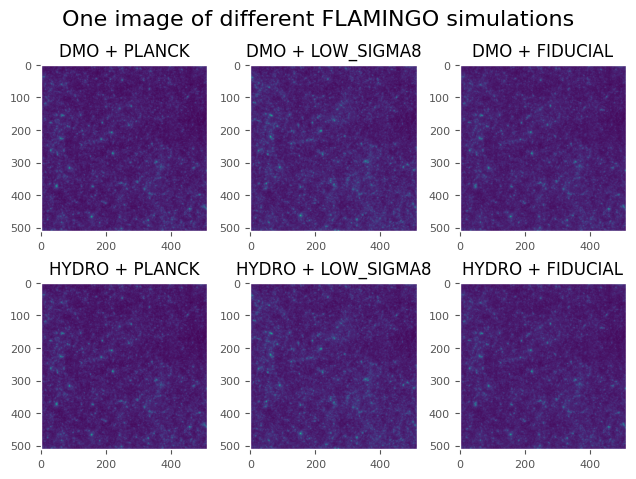

In [51]:
SMALL_SIZE = 8
MEDIUM_SIZE = 12
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

f, ax = plt.subplots(2, 3)
f.suptitle("One image of different FLAMINGO simulations")

for i, typ in enumerate(types):
    for j, sim in enumerate(sims):
        ax[i][j].imshow(projections[typ][sim][0])
        ax[i][j].set_title(typ + " + "+ sim)
        ax[i][j].grid()
plt.tight_layout()
plt.savefig("figs/flamingo_figs.pdf")
plt.show()

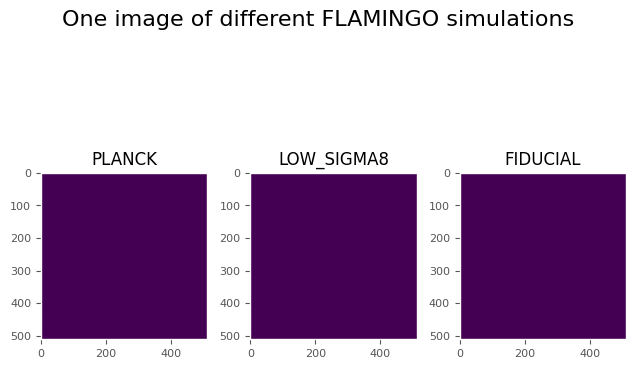

In [52]:
f, ax = plt.subplots(1, 3)
f.suptitle("One image of different FLAMINGO simulations")
for j, sim in enumerate(sims):
    ax[j].imshow(projections[types[0]][sim][1]-projections[types[1]][sim][1])
    ax[j].set_title(sim)
    ax[j].grid()
plt.tight_layout()
plt.show()

In [37]:
a = (projections[types[0]][sims[0]][4]-projections[types[1]][sims[0]][4])
print(np.var(a))

0.0


Skewness: 2.95 || Kurtosis: 24.47


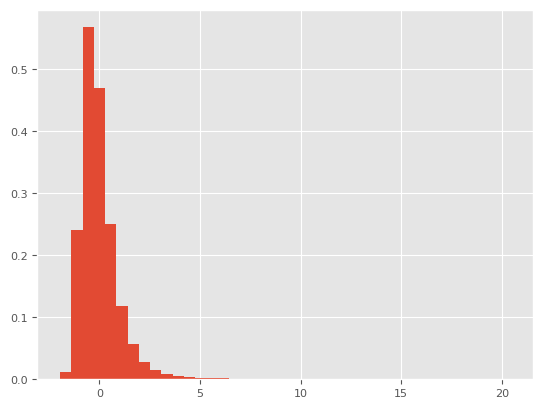

The resulting parameters:
  Lambda_1 = -0.392
  Lambda_2 = -0.776
  Lambda_3 = 0.159
  Lambda_4 = -0.008


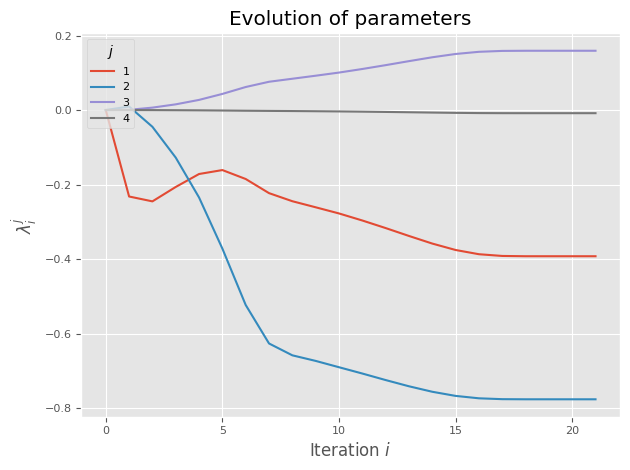

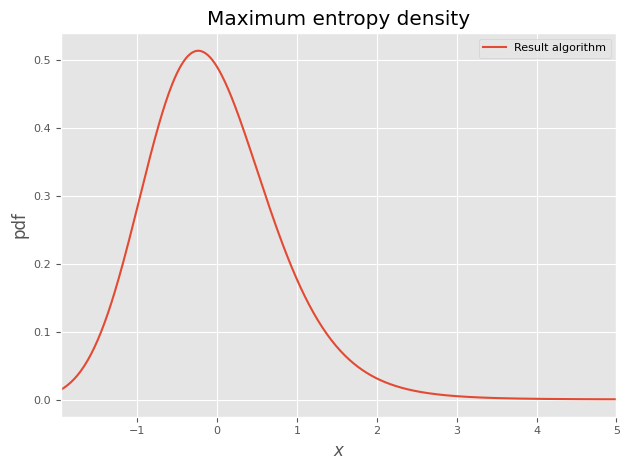

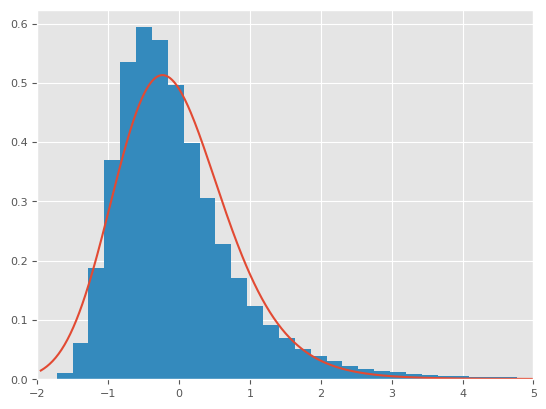

In [ ]:
for i in range(1):
    arr = (projections[types[0]][sims[0]][1]).flatten()
    mu = np.mean(arr)
    s2 = np.var(arr)
    arr_standard = (arr-mu)/np.sqrt(s2)
    skew = np.mean(arr_standard**3)
    kurt = np.mean(arr_standard**4)
    print(f"Skewness: {skew:.2f} || Kurtosis: {kurt:.2f}")

    plt.hist(arr_standard, density=True, bins=40)
    plt.show()
    
    l = np.min(arr_standard)
    u = np.max(arr_standard)
    n = 150

    ob_skewkurt = MaxEnt(support=(l,u),
                        n_quadrature=n,
                        b_constraints=d.b_constraint_skewkurt(skew,kurt),
                        f_vector=d.f_constraint_skewkurt)
    ob_skewkurt.visualize_algorithm()
    ob_skewkurt.visualize_solution(xlim=(l,5))

    N=500
    xx = np.linspace(l,5,N)

    y = ob_skewkurt.pdf(xx)
    plt.plot(xx,y)
    plt.hist(arr_standard, density=True, bins=100)
    plt.xlim(-2,5)
    plt.show()

In [14]:
# Z = rfft2(im)

# f, (ax1, ax2) = plt.subplots(1, 2)#, sharex='col', sharey='row'

# ax1.imshow(im)#, cmap=cm.Reds
# ax2.imshow(np.real(Z), cmap=cm.gray)
# plt.show()
# print(Z)

In [53]:
def batch_rejection_sample(density, xlim, C, N):
    Y = np.random.uniform(*xlim,size=N)
    U = np.random.uniform(size=N)
    mask = (U <= (xlim[1]-xlim[0])*density(Y)/C)
    return Y[mask]

def rejection_sampling(size, density, xlim, n_batch=5000):
    """Univariate rvs, on closed support [a,b]
    - density should be vectorizable"""

    # Determine C s.t. density(x) <= C * (b-a)^-1
    N = 10000
    xx = np.linspace(*xlim,N)
    yy = density(xx)
    C = np.max(yy)*(xlim[1]-xlim[0])
    
    results = np.array([])
    while(results.size<size):
        results = np.append(results, batch_rejection_sample(density,xlim,
                                                            C,N=1000))
    
    return results[:size]



In [58]:
def standardize_image(image):
    mean = np.mean(image)
    var = np.var(image)
    return (image-mean)/np.sqrt(var)

def generate_copy_image(image_raw, 
                        name,
                        extra_upper_l=0.00, 
                        n=150, 
                        u_show=None):
    
    image = standardize_image(image_raw)
    image_flat = image.flatten()

    l = np.min(image)
    u = np.max(image) + extra_upper_l

    if(u_show == None):
        u_show = u

    skew = np.mean(image_flat**3)
    kurt = np.mean(image_flat**4)

    ob_skewkurt = MaxEnt(support=(l,u),
                        n_quadrature=n,
                        b_constraints=d.b_constraint_skewkurt(skew,kurt),
                        f_vector=d.f_constraint_skewkurt,
                        k_max=200, 
                        message_norm=False)
    # ob_skewkurt.visualize_algorithm()
    # ob_skewkurt.visualize_solution(xlim=(l,5))


    #sample from ME distribution
    n_sample = image_flat.size
    sample_ME = rejection_sampling(size=n_sample, 
                                   density=ob_skewkurt.pdf, 
                                   xlim=(l,u),
                                   n_batch=1000)
    
    res_sample = kstest(image_flat, sample_ME)
    n_breaks = 50
    bins = np.linspace(l, u_show, n_breaks)

    fig, ax = plt.subplots(2,1)
    ax[0].imshow(image_raw)

    ax[0].set_title(f"Raw image {name}")
    ax[0].grid()
    
    ax[1].hist(image_flat, density=True, bins=bins, alpha=0.6, label="Real")
    ax[1].hist(sample_ME,  density=True, bins=bins, alpha=0.6, label="Sampled")

    ax[1].set_title(f"Histogram of pixel values ($p$-val. KS: {res_sample.pvalue:.1e})")
    ax[1].set_xlabel("Pixel value")
    ax[1].set_ylabel("Density")
    ax[1].set_xlim(l, u_show)
    # ax[1].set_yscale("log")
    ax[1].legend()

    plt.tight_layout()
    plt.savefig(f"figs/generated_copy_{name}.pdf")
    plt.show()

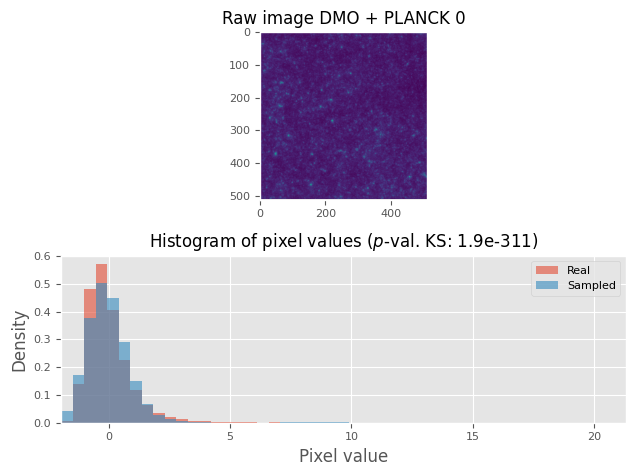

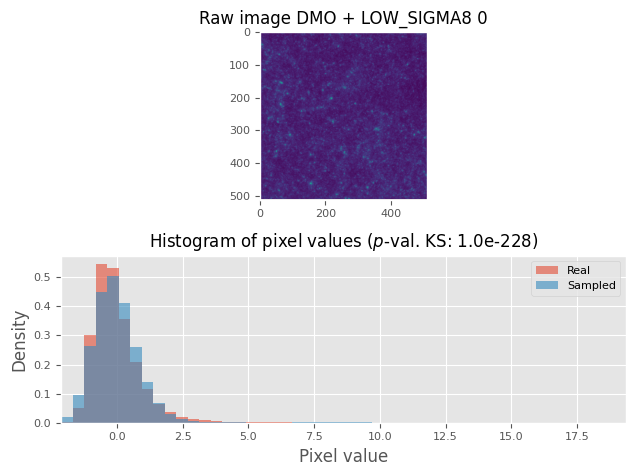

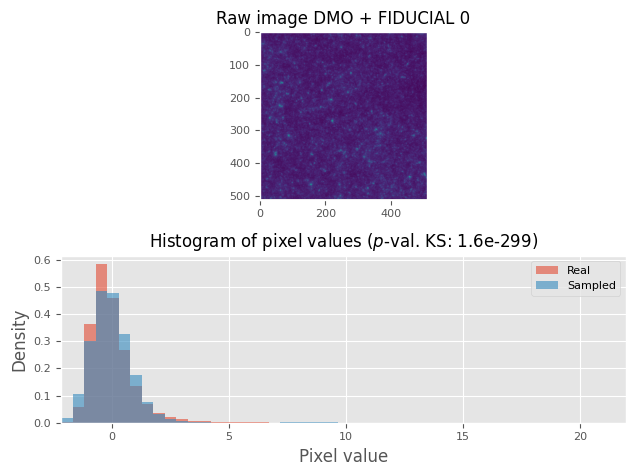

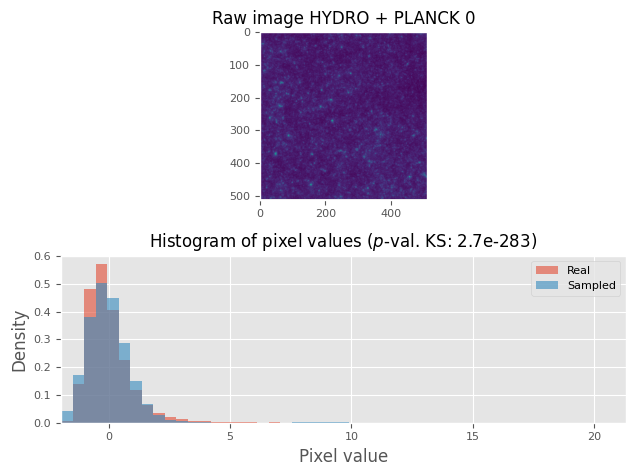

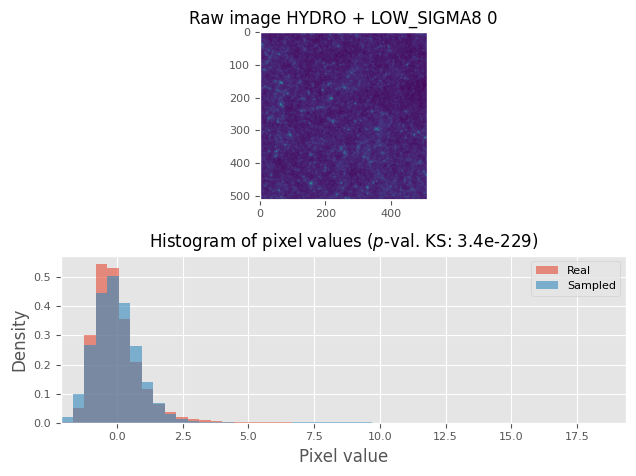

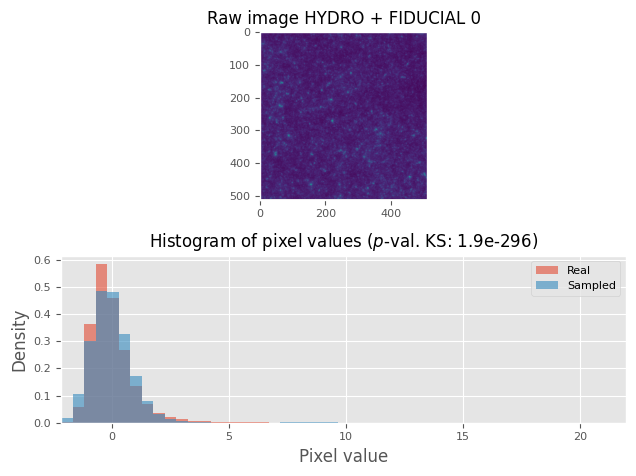

In [59]:
k=0
for i, typ in enumerate(types):
    for j, sim in enumerate(sims):
        generate_copy_image(projections[typ][sim][k],
                        name=typ+" + "+sim+f" {k}",
                        n=250)

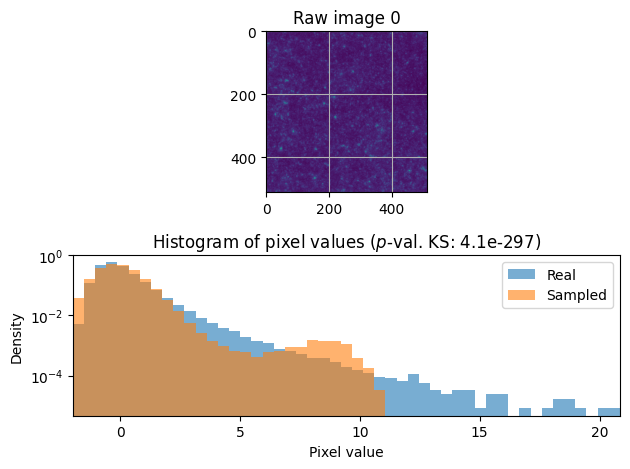

In [ ]:
#logarithmic plot
# for i in range(1):
#     generate_copy_image(projections[i],
#                         ,
#                         extra_upper_l=0, 
#                         n=150)